In [3]:
import sys
!{sys.executable} -m pip install sklearn

  Using cached sklearn-0.0.tar.gz (1.1 kB)
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=0cac82414c4e4a7c3a1b0ece85c109c3fa1d582c1ce442fde1e8a6b8d05bd8d7
  Stored in directory: /Users/aristophanesalbertusalvin/Library/Caches/pip/wheels/e4/7b/98/b6466d71b8d738a0c547008b9eb39bf8676d1ff6ca4b22af1c
Successfully built sklearn


In [13]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [16]:
# Load data from .txt files and make the train-test splits.
# Since we're working with text data, we need to vectorize the documents / turn each document
# into a point vector in a n-dimentions space. 
# Moreover, rather than simply using the word counts, we want to use the Term Frequency as feature value.

review_files = load_files('./cleaned_op_spam', encoding='latin-1')
x_train, x_test, y_train, y_test = train_test_split(review_files.data, review_files.target, test_size=0.2)

vectorizer = TfidfVectorizer(stop_words='english')
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test)
# print(x_trainvec.toarray())
# print(vectorizer.get_feature_names_out())

print('===== Target classes =====')
print(review_files.target_names)
# print(review_files)

===== Target classes =====
['negative deceptive', 'negative truthful', 'positive deceptive', 'positive truthful']


In [8]:
# Fit and test the models

print("===== COMPARISON OF SIMPLE MODELS (no fine-tuning of hyperparameters) =====\n")

mnb = MultinomialNB()
preds_mnb = mnb.fit(x_train_vec, y_train).predict(x_test_vec)
print("MNB correct predictions %d out of %d. Score %.3f" % ((y_test == preds_mnb).sum(), x_test_vec.shape[0], (y_test == preds_mnb).sum() / x_test_vec.shape[0]))

loreg1 = LogisticRegression(solver='lbfgs')
preds_logreg1 = loreg1.fit(x_train_vec, y_train).predict(x_test_vec)
print("LReg-LBFGS correct predictions %d out of %d. Score %.3f" % ((y_test == preds_logreg1).sum(), x_test_vec.shape[0], (y_test == preds_logreg1).sum() / x_test_vec.shape[0]))

logreg2 = LogisticRegression(solver='liblinear')
preds_logreg2 = logreg2.fit(x_train_vec, y_train).predict(x_test_vec)
print(f"LReg-Liblinear correct predictions {(y_test == preds_logreg2).sum()} out of {x_test_vec.shape[0]}. Score {round((y_test == preds_logreg2).sum() / len(y_test), 3)}")

logreg3 = LogisticRegression(solver='saga')
preds_logreg3 = logreg3.fit(x_train_vec, y_train).predict(x_test_vec)
print(f"LReg-Saga correct predictions {(y_test == preds_logreg3).sum()} out of {x_test_vec.shape[0]}. Score {round((y_test == preds_logreg3).sum() / len(y_test), 3)}")

dectree = DecisionTreeClassifier()
preds_dectree = dectree.fit(x_train_vec, y_train).predict(x_test_vec)
print(f"Decision Tree correct predictions {(y_test == preds_dectree).sum()} out of {x_test_vec.shape[0]}. Score {round((y_test == preds_dectree).sum() / len(y_test), 3)}")

rforest = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
preds_rforest = rforest.fit(x_train_vec, y_train).predict(x_test_vec)
print(f"Random Forest correct predictions {(y_test == preds_rforest).sum()} out of {len(y_test)}. Score {round((y_test == preds_rforest).sum() / len(y_test), 3)}")

===== COMPARISON OF SIMPLE MODELS (no fine-tuning of hyperparameters) =====

MNB correct predictions 265 out of 320. Score 0.828
LReg-LBFGS correct predictions 262 out of 320. Score 0.819
LReg-Liblinear correct predictions 260 out of 320. Score 0.812
LReg-Saga correct predictions 262 out of 320. Score 0.819
Decision Tree correct predictions 145 out of 320. Score 0.453
Random Forest correct predictions 183 out of 320. Score 0.572


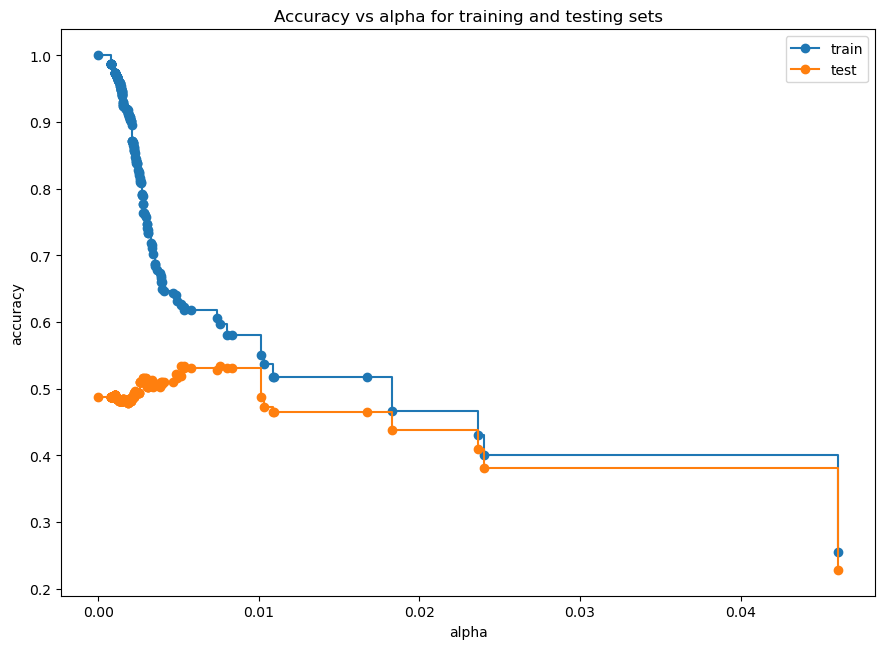

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [9]:
# Attempt to optimize the Decision Tree using Cost-Complexity Pruning technique

path = dectree.cost_complexity_pruning_path(x_train_vec, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
# print(ccp_alphas)
# print(impurities)

dtrees = []
for ccp_alpha in ccp_alphas:
    dtr = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    dtr.fit(x_train_vec, y_train)
    dtrees.append(dtr)
# print(f"Number of nodes in the last tree is: {dectrees[-1].tree_.node_count} with ccp_alpha: {ccp_alphas[-1]}")

train_scores = [dtr.score(x_train_vec, y_train) for dtr in dtrees]
test_scores = [dtr.score(x_test_vec, y_test) for dtr in dtrees]

fig, ax = plt.subplots()
fig.set_size_inches(10.5, 7.5)
fig.set_dpi(100)
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()
fig.savefig('decisiontree-alphapruning-plot.eps', format='eps')

# CONCLUSION: Accuracy optimizes at alpha 0.01. However, the score remains at ±52% so there is no noticeable 
# improvement achieved by the cost-complexity pruning, compared to the simple un-pruned tree.

In [20]:
neg_dec_prob_sorted = mnb.feature_log_prob_[0, :].argsort()[::-1]
neg_tru_prob_sorted = mnb.feature_log_prob_[1, :].argsort()[::-1]
pos_dec_prob_sorted = mnb.feature_log_prob_[2, :].argsort()[::-1]
pos_tru_prob_sorted = mnb.feature_log_prob_[3, :].argsort()[::-1]

print("===== CLASS PREDICTORS =====")
print(f"Negative Deceptive \n predictors: {np.take(vectorizer.get_feature_names_out(), neg_dec_prob_sorted[:10])}")
print(f"likelihood: {neg_dec_prob_sorted[:10]}\n")
print(f"Negative Truthful \n predictors: {np.take(vectorizer.get_feature_names_out(), neg_tru_prob_sorted[:10])}")
print(f"likelihood: {neg_tru_prob_sorted[:10]}\n")
print(f"Positive Deceptive \n predictors: {np.take(vectorizer.get_feature_names_out(), pos_dec_prob_sorted[:10])}")
print(f"likelihood: {pos_dec_prob_sorted[:10]}\n")
print(f"Positive Truthful \n predictors: {np.take(vectorizer.get_feature_names_out(), pos_tru_prob_sorted[:10])}")
print(f"likelihood: {pos_tru_prob_sorted[:10]}\n")

===== CLASS PREDICTORS =====
Negative Deceptive 
 predictors: ['room' 'hotel' 'chicago' 'stay' 'service' 'like' 'did' 'desk'
 'experience' 'night']
likelihood: [6263 3732 1464 7044 6528 4353 2249 2213 2844 4963]

Negative Truthful 
 predictors: ['room' 'hotel' 'stay' 'night' 'did' 'desk' 'service' 'called' 'staff'
 'good']
likelihood: [6263 3732 7044 4963 2249 2213 6528 1266 6993 3373]

Positive Deceptive 
 predictors: ['hotel' 'chicago' 'stay' 'great' 'room' 'staff' 'rooms' 'service'
 'comfortable' 'definitely']
likelihood: [3732 1464 7044 3425 6263 6993 6265 6528 1637 2134]

Positive Truthful 
 predictors: ['great' 'hotel' 'room' 'location' 'staff' 'stay' 'chicago' 'stayed'
 'clean' 'comfortable']
likelihood: [3425 3732 6263 4422 6993 7044 1464 7045 1535 1637]



In [27]:
def run_cross_validation(nfolds, ngram=1):
    tf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(ngram, ngram))
    x_train_vec = tf_vectorizer.fit_transform(review_files.data)
    y_train_vec = review_files.target

    mnbayes = MultinomialNB()
    logreg = LogisticRegression(solver='lbfgs')
    logreg2 = LogisticRegression(solver='liblinear')
    logreg3 = LogisticRegression(solver='saga')
    dtree = DecisionTreeClassifier()
    ranForest = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
    
    # Naive Bayes
    bayes_acc = cross_val_score(mnbayes, x_train_vec, y_train_vec, cv=nfolds, scoring='accuracy').mean()
    bayes_prec = 0 #cross_val_score(mnbayes, x_train_vec, y_train_vec, cv=nfolds, scoring='precision').mean()
    bayes_rec = 0 #cross_val_score(mnbayes, x_train_vec, y_train_vec, cv=nfolds, scoring='recall').mean()
    
    #Logistic regression
    lg_acc = cross_val_score(logreg, x_train_vec, y_train_vec, cv=nfolds, scoring='accuracy').mean()
    lg_prec = 0 #cross_val_score(logreg, x_train_vec, y_train_vec, cv=nfolds, scoring='precision').mean()
    lg_rec = 0 #cross_val_score(logreg, x_train_vec, y_train_vec, cv=nfolds, scoring='recall').mean()
    
    lg2_acc = cross_val_score(logreg2, x_train_vec, y_train_vec, cv=nfolds, scoring='accuracy').mean()
    lg2_prec = 0 #cross_val_score(logreg2, x_train_vec, y_train_vec, cv=nfolds, scoring='precision').mean()
    lg2_rec = 0 #cross_val_score(logreg2, x_train_vec, y_train_vec, cv=nfolds, scoring='recall').mean()
    
    lg3_acc = cross_val_score(logreg3, x_train_vec, y_train_vec, cv=nfolds, scoring='accuracy').mean()
    lg3_prec = 0 #cross_val_score(logreg3, x_train_vec, y_train_vec, cv=nfolds, scoring='precision').mean()
    lg3_rec = 0 #cross_val_score(logreg3, x_train_vec, y_train_vec, cv=nfolds, scoring='recall').mean()
    
    # Decision Tree
    dt_acc = cross_val_score(dtree, x_train_vec, y_train_vec, cv=nfolds, scoring='accuracy').mean()
    dt_prec = 0 #cross_val_score(dtree, x_train_vec, y_train_vec, cv=nfolds, scoring='precision').mean()
    dt_rec = 0 #cross_val_score(dtree, x_train_vec, y_train_vec, cv=nfolds, scoring='recall').mean()
    
    # Random Forest
    ranForest_acc = cross_val_score(ranForest, x_train_vec, y_train_vec, cv=nfolds, scoring='accuracy').mean()
    ranForest_prec = 0 #cross_val_score(ranForest, x_train_vec, y_train_vec, cv=nfolds, scoring='precision').mean()
    ranForest_rec = 0 #cross_val_score(ranForest, x_train_vec, y_train_vec, cv=nfolds, scoring='recall').mean()
    
    print(f'         Model                         | Accuracy | Precision | Recall')
    print(f'Naive Bayes                            | {round(bayes_acc, 3)}    | {round(bayes_prec, 3)}    | {round(bayes_rec, 3)}')
    print(f'Logistic Regression - LBFGS solver     | {round(lg_acc, 3)}    | {round(lg_prec, 3)}    | {round(lg_rec, 3)}')
    print(f'Logistic Regression - Liblinear solver | {round(lg2_acc, 3)}    | {round(lg2_prec, 3)}    | {round(lg2_rec, 3)}')
    print(f'Logistic Regression - Saga solver      | {round(lg3_acc, 3)}    | {round(lg3_prec, 3)}    | {round(lg3_rec, 3)}')
    print(f'Decision Tree                          | {round(dt_acc, 3)}    | {round(dt_prec, 3)}    | {round(dt_rec, 3)}')
    print(f'Random Forest                          | {round(ranForest_acc, 3)}    | {round(ranForest_prec, 3)}    | {round(ranForest_rec, 3)}')

In [28]:
print('===== UNIGRAM, 5 folds cv =====')
run_cross_validation(nfolds=5, ngram=1)

print('\n===== UNIGRAM, 10 folds cv =====')
run_cross_validation(nfolds=10, ngram=1)

print('\n===== UNIGRAM, 15 folds cv =====')
run_cross_validation(nfolds=15, ngram=1)

print('\n===== BIGRAM, 5 folds cv =====')
run_cross_validation(nfolds=5, ngram=2)

print('\n===== BIGRAM, 10 folds cv =====')
run_cross_validation(nfolds=10, ngram=2)

print('\n===== BIGRAM, 15 folds cv =====')
run_cross_validation(nfolds=15, ngram=2)

===== UNIGRAM, 5 folds cv =====
         Model                         | Accuracy | Precision | Recall
Naive Bayes                            | 0.791    | 0    | 0
Logistic Regression - LBFGS solver     | 0.817    | 0    | 0
Logistic Regression - Liblinear solver | 0.817    | 0    | 0
Logistic Regression - Saga solver      | 0.817    | 0    | 0
Decision Tree                          | 0.503    | 0    | 0
Random Forest                          | 0.593    | 0    | 0

===== UNIGRAM, 10 folds cv =====
         Model                         | Accuracy | Precision | Recall
Naive Bayes                            | 0.795    | 0    | 0
Logistic Regression - LBFGS solver     | 0.823    | 0    | 0
Logistic Regression - Liblinear solver | 0.816    | 0    | 0
Logistic Regression - Saga solver      | 0.823    | 0    | 0
Decision Tree                          | 0.519    | 0    | 0
Random Forest                          | 0.579    | 0    | 0

===== UNIGRAM, 15 folds cv =====
         Model            

In [26]:
# Attempt to optimize the Logistic Regression using Regularization

def run_logistic_regression_cv(nfold, ngram):
    tf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(ngram, ngram))
    X = tf_vectorizer.fit_transform(review_files.data)
    y = review_files.target

    logreg1 = LogisticRegressionCV(solver='liblinear', cv=nfold, penalty='l1', max_iter=2500)
    logreg1.fit(X, y)
    score_logreg1 = logreg1.score(X, y)


    logreg2 = LogisticRegressionCV(solver='saga', cv=nfold, penalty='l1', max_iter=2500)
    logreg2.fit(X, y)
    score_logreg2 = logreg2.score(X, y)
    
    print('Here are the scores')
    print(score_logreg1)
    print(score_logreg2)
    
    print("===== Here are the C values =====")
    print(logreg1.Cs_)
    print(logreg2.Cs_)


import time
start = time.time()
run_logistic_regression_cv(5, 1)
end = time.time()
print(f'Elapsed time: {end-start}')

Here are the scores
0.999375
1.0
===== Here are the C values =====
[1.00000000e-04 7.74263683e-04 5.99484250e-03 4.64158883e-02
 3.59381366e-01 2.78255940e+00 2.15443469e+01 1.66810054e+02
 1.29154967e+03 1.00000000e+04]
[1.00000000e-04 7.74263683e-04 5.99484250e-03 4.64158883e-02
 3.59381366e-01 2.78255940e+00 2.15443469e+01 1.66810054e+02
 1.29154967e+03 1.00000000e+04]
Elapsed time: 482.02586698532104
